#### Why another activation function? Rectified linear worked pretty well.

Consider the following:

layer_outputs = [4.8, 1.21, 2.385] 

In this case, index 0 would be the largest value and thus the model's prediction.

But, how wrong is the model? We need a model that can illustrate relative comparisons between outputs 
beyond simple accuracy. For instance, if instead we had:

layer outputs = [4.8, 4.79, 4.25]

We wouldn't know *how* correct the model would be in identifying index 0 as the class prediction. 

Moreover, these output values are unbounded, so relative closeness can vary considerably depending on inputs from previous layers. 

A formal, uniform determination of output values requires a new activation function: Softmax.

#### Ideally, output layer values will be probability distributions between 0 and 1.

Could I just normalize values between 0 and 1 and use relative proportions? Not if I have negative values! ReLU will clip them to zero. Could I use a linear activation function? Maybe squared values or absolutes? These are not final values - I need to use these values to train the model. So, I can't just mess around with outputs to get something that approximates a probability distribution. I need values between 0 and 1 that actually represent differences between outputs.

#### Enter: Exponential Function.

y = e^x

e ~= 2.718281... (euler's number)

This ensures no output value can be negative no matter the x, while also preserving the scale of outputs to allow for adequate comparisons. 

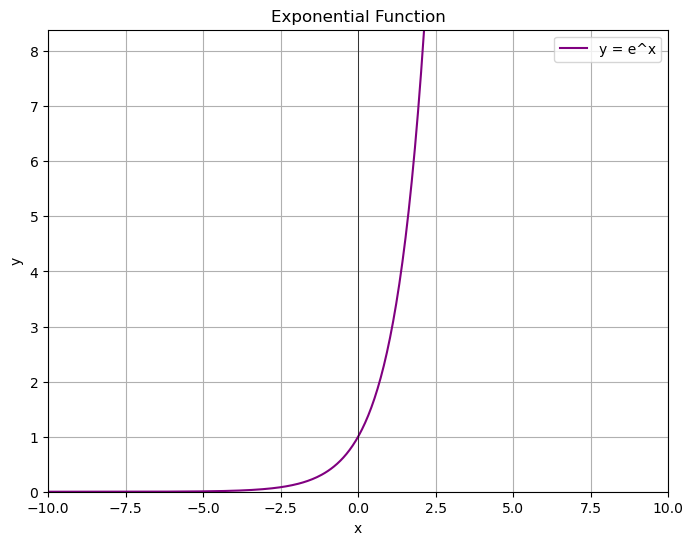

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the exponential function
def exponential(x):
    return np.exp(x)

# Generate x values
x = np.linspace(-10, 10, 400)
y = exponential(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='y = e^x', color='purple')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, which='both')

# Set the x and y axis limits
plt.xlim([-10, 10])
plt.ylim([0, np.exp(2) + 1])

# Label the plot
plt.title('Exponential Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()


#### Coding exponentiation in the activation function.

In [11]:
import math

layer_outputs = [4.8, 1.21, 2.385] 

E = math.e

exp_values = [E**x for x in layer_outputs]

print("Exponentiated values: ", exp_values)

Exponentiated values:  [121.51041751873483, 3.353484652549023, 10.859062664920513]


#### Exponentiation fixes the negative issue while maintaining scale. But now I need to normalize values to get them between 0 and 1.

y = single neuron output value / sum of all neuron outputs in that layer

This gives a probability distribution that we want. Remember to exponentiate first!

In [13]:
import math

layer_outputs = [4.8, 1.21, 2.385] 

E = math.e

exp_values = [E**x for x in layer_outputs]

norm_base = sum(exp_values)
norm_values = [val/norm_base for val in exp_values]

print("Normalized values: ", norm_values)
print()
print("Sum of norm vals: ", sum(norm_values))

Normalized values:  [0.8952826639572619, 0.024708306782099374, 0.0800090292606387]

Sum of norm vals:  0.9999999999999999


#### Next, convert all this to numpy.

In [17]:
import numpy as np
import nnfs

nnfs.init()

layer_outputs = [4.8, 1.21, 2.385] 

exp_values = np.exp(layer_outputs) # vectorized operation avoids the for loop and increases performance

norm_values= exp_values / np.sum(exp_values)

print("Normalized values: ", norm_values)
print()
print("Sum of norm vals: ", sum(norm_values))

Normalized values:  [0.89528266 0.02470831 0.08000903]

Sum of norm vals:  0.9999999999999999


#### Softmax Activation = input -> exponentiation -> normalization

The softmax activation function is defined as:

$$
S_i,j = \frac{e^{z_i,j}}{\sum_{l=1}^{L} e^{z_i,j}}
$$

where:
- \( z \) is the input vector.
- \( L \) is the number of classes.
- \( S_i,j \) is the output of the softmax function for the \(i\)-th class.

#### Unlike the example, we won't have a single set of outputs, but we'll have a batch out outputs.

In [25]:
import numpy as np
import nnfs

nnfs.init()

layer_outputs = [[4.8, 1.21, 2.385], 
                 [8.9, -1.81, 0.82],
                 [1.41, 1.051, 0.026]]

exp_values = np.exp(layer_outputs) # work element wise, so this works on batches...

# however, np.sum will return a single scalar value for all three vectors. But I need three sums - one for each batch.

# this is done by passing the axis parameter

print("Sum of layer outputs with Axis = none: ", np.sum(layer_outputs, axis=None))
print("Sum of layer outputs with Axis = 0: ", np.sum(layer_outputs, axis = 0)) # sum of values column wise
print("Sum of layer outputs with Axis = 1: ", np.sum(layer_outputs, axis = 1)) # sum of values row wise
print()

print("Sum of layer outputs with Axis = 1 and dimensions retained: ") # prevents need for transposition
print(np.sum(layer_outputs, axis = 1, keepdims=True))
print()


norm_values = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
print("Normalized Values as exp_val / sum(exp_val) with Axis 1 and dimensions retained:")
print(norm_values)
# I need row wise values


# print("Normalized values: ", norm_values)
# print()
# print("Sum of norm vals: ", sum(norm_values))

Sum of layer outputs with Axis = none:  18.792
Sum of layer outputs with Axis = 0:  [15.11   0.451  3.231]
Sum of layer outputs with Axis = 1:  [8.395 7.91  2.487]

Sum of layer outputs with Axis = 1 and dimensions retained: 
[[8.395]
 [7.91 ]
 [2.487]]

Normalized Values as exp_val / sum(exp_val) with Axis 1 and dimensions retained:
[[8.95282664e-01 2.47083068e-02 8.00090293e-02]
 [9.99668119e-01 2.23132042e-05 3.09568261e-04]
 [5.13097164e-01 3.58333899e-01 1.28568936e-01]]


#### A slight issue with exponentiation...

Outputs grow really quickly as function passes higher values. To deal with this, we can subtract largest value in layer from every value in the layer, essentially reducing the whole layer to max of 0. 

v = u - max(u)

u = [1 2 3], max u = 3

v = [1 2 3] - 3 = [-2 -1 0]

Now, range of possible outputs after exponentiation lies between 0 and 1 because e^0 = 1.

What sort of impact will this approach have to the output of the softmax activation?
The output is actually the same - we've just protected ourselves from an overflow error by passing values greater than 0 to the exponential function.

With that in mind, here's the full framework up to this point...

In [31]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):      
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons)) 
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0,inputs)
        
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        
X,y = spiral_data(samples=100, classes=3) # initialize random spiral data with 3 classes and two input features over 100 batches

dense1 = Layer_Dense(2,3) # create first layer, receiving 2 inputs and passing to 3 output neurons
activation1 = Activation_ReLU() # initialize ReLU

dense2 = Layer_Dense(3,3) # create output layer, receiving 3 inputs from layer 1 and passing to 3 classes as defined in X,y above
activation2 = Activation_Softmax() # initialize output layer activation, Softmax

dense1.forward(X) # pass training data into first layer
activation1.forward(dense1.output) # apply ReLU to clip values below zero

dense2.forward(activation1.output) # pass clipped values from layer 1 to final layer
activation2.forward(dense2.output) # apply Softmax to treat negatives and normalize range to 0,1 to produce probabilities

print("Output probabilities: ", "\n",activation2.output[:5]) # returns first 5/100 sets of 3 probabilities each, representing one prob for each class


Output probabilities:  
 [[0.33333334 0.33333334 0.33333334]
 [0.33331734 0.3333183  0.33336434]
 [0.3332888  0.33329153 0.33341965]
 [0.33325943 0.33326396 0.33347666]
 [0.33323312 0.33323926 0.33352762]]


#### Class distribution is almost equal because initialized weights were random.
#### The next step is to train this model by implementing a loss function.